# **Emotion Recognition using Multimodal Deep Learning Approaches**

In this experiment we propose a novel Multimodal Architecture to predict 8 different human emotions. We use audio and video as inputs to our model. The dataset this notebook runs on is the SAVEE datatset


In [ ]:
!pip install av

try:
    from torchsummary import summary
except:
    !pip install torchsummary
    from torchsummary import summary

try:
    from torcheval.metrics.functional import multiclass_f1_score
except:
    !pip install torcheval
    from torcheval.metrics.functional import multiclass_f1_score

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import re

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sn

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image, read_video

import torchaudio

import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from IPython.display import HTML, Video

import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

import gc

# !pip install pytorchvideo

from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip, Resize, ToTensor, ToPILImage, CenterCrop, ColorJitter, RandomPerspective

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import inspect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.8 MB/s eta 0:00:00


## **Setting up environment & hyperparameters**

In [ ]:
# Set up device: use GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
"""
    Uncomment this line if running from Google Colab
"""

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    torch.cuda.get_device_name(0)
except:
    print("No CUDA. CPU available")

In [ ]:
# The path to the root directory of the dataset. Change this on your system
working_dir = "/path_to_savee/"

In [ ]:
# Hyperparameters. Tweak as you wish
hyperparams = {
    "lr": 0.0001, # Learning Rate
    "epochs": 30, # Number of Epochs
    "adam_betas": (0.98, 0.999), # B1 and B2 (weight decays) of ADAM
    "batch": 16, # Mini-batch size
    "sdg_momentum": 0.99, # Stochastic Gradient Descent momentum
    "sdg_weight_decay": 0.45, # Stochastic Gradient Descent weight decay,
}

hyperparams

{'lr': 0.0001,
 'epochs': 30,
 'adam_betas': (0.98, 0.999),
 'batch': 16,
 'sdg_momentum': 0.99,
 'sdg_weight_decay': 0.45,
 'num_features': 1024,
 'max_seq_len': 120}

In [ ]:
# A dict that maps the class name to our assigned index (uses: track emotion index for prediction)
"""
This is for RAVDESS ONLY. Migrations for SAVEE and CREMA-D will be made later
"""
class2idx = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happiness": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6,
}

# A dict that maps the index to the class name (uses: decorate prediction)
idx2class = {v:k for k,v in class2idx.items()}

# A dict that maps the type given in the file name to our index(uses: dataset preparation)
tag2idx = {
    "a": 0,
    "d": 1,
    "f": 2,
    "h": 3,
    "n": 4,
    "sa": 5,
    "su": 6,
}

In [ ]:
idx2class

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

## **Defining the Transforms(Augmentation Techniques) and helper functions**

In [ ]:
# Defining the transforms:
video_frame_transform = Compose([
    ToPILImage(),
    Resize((252,252)),
    CenterCrop((184,184)),
    ToTensor()
])

# change frame color randomly
video_frame_augment_color = Compose([
    ToPILImage(),
    Resize((252,252)),
    CenterCrop((184,184)),
    ColorJitter(brightness=0.4, hue=0.3, saturation=0.4),
    ToTensor()
])

# change frame prespective randomly
video_frame_augment_persp = Compose([
    ToPILImage(),
    Resize((252,252)),
    CenterCrop((184,184)),
    RandomPerspective(distortion_scale=0.3, p=1.0),
    ToTensor()
])


In [ ]:
"""
    Defining the helper functions for the Audio mel-spectogram technique
"""

# Get the melspec of the audio as image/np 2d array
def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)


# Show the image spectogram
def imgSpec(ms_feature):
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');

# Hear the audio
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)

    print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr))


def show_video(video_path):
    from base64 import b64encode

    if os.path.isfile(video_path):
        ext = '.mp4'
    else:
        print("Error: Please check the path.")

    video_encoded = open(video_path, "rb").read()
    data = "data:video/mp4;base64," + b64encode(video_encoded).decode()

    video_tag = '<video width="400" height="300" controls alt="test" src="%s">' % data
    return HTML(data=video_tag)

# Show 1 example
def show_example(video_path, audio_path, prediction=None, actual=None, save_memory=False):
    if prediction is not None:
        print("Predicted Label:", idx2class[prediction])
    print("Actual Label:", idx2class[actual])

    if save_memory is False:
        print("Video path:", video_path)
        ipd.display(Video(video_path, embed=True))

        # display(show_video(video_path))
        print("Audio path:", audio_path)
        hear_audio(audio_path)

In [ ]:
"""
    Defining the helper functions for the Audio MFCC technique
"""

# audio effects
def audio_effects(audio, sample_rate, augment=1):
    data = None
    if augment == 1:
        data = librosa.effects.harmonic(y=audio)
    elif augment == 2:
        data = librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=3)
    return data


# normalize the audio wave
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

def feature_extractor(file, augment=0, test=False):

    attempt = 0
    while True:
        try:
            data, sample_rate = librosa.load(file)
            break
        except:
            if attempt == 50:
                print("failed trying to find audio file", file)
                break
            print("Audio file not read. Trying again")
            attempt += 1

#     print(data.shape)

    if augment > 0:
        data = audio_effects(data, sample_rate, augment=augment)

    data = normalize_audio(data)

    # zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=data)[0]
    zcr /= zcr.max()
    zcr = zcr[0:(0+128)]
    if len(zcr) < 128:
        zcr = librosa.util.fix_length(zcr, size=128)
#     result=np.vstack((result, zcr))


    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=128).T, axis=0)
    mfcc /= mfcc.max()
#     result = np.vstack((result, mfcc))

    # Root Mean Square Value
    rms = librosa.feature.rms(y=data)[0]
    rms /= rms.max()
    rms = rms[0:(0+128)]
    if len(rms) < 128:
        rms = librosa.util.fix_length(rms, size=128)
#     result = np.vstack((result, rms))

    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    mel = librosa.amplitude_to_db(mel, ref = np.max)
    mel = np.mean(mel.T, axis=0)
    mel /= mel.sum()
#     result = np.vstack((result, mel))

    if test:
        return_dict = {
            "raw": data,
            "sr": sample_rate,
            "zcr": zcr,
            "mfcc": mfcc,
            "rms": rms,
            "mel": mel
        }
    else:
        return_dict = {
            "zcr": zcr,
            "mfcc": mfcc,
            "rms": rms,
            "mel": mel
        }
    return return_dict

In [ ]:
def dict_to_tensor(dictionary):
    out_dict = {}
    for item in dictionary.items():
        if item[0] == "sr":
            out_dict[item[0]] = torch.tensor(item[1]).to(device)
        else:
            out_dict[item[0]] = torch.from_numpy(item[1]).to(device)

    return out_dict

<br/>

---

<br/>

## **Dataset Preparation**

In [ ]:
# Make a tuple of audio, video, labels
def make_ds_as_list(path):
    audio = []
    video = []
    labels = []
    for dirname, _, filenames in sorted(os.walk(f"{path}Video")):
        for filename in sorted(filenames):
            if filename == "Info.txt":
                continue

            video_path = os.path.join(dirname, filename)
            label = re.split("(\d+)", filename)[0]
            label = tag2idx[label]
            video.append(video_path)
            labels.append(label)


    for dirname, _, filenames in sorted(os.walk(f"{path}Audio")):
        for filename in sorted(filenames):
            if filename == "Info.txt":
                continue

            audio_path = os.path.join(dirname, filename)
            audio.append(audio_path)

    return audio, video, labels

# Create a dataframe
def make_dataframe(path, augment=0):
    audio, video, labels = make_ds_as_list(path)
    data = pd.DataFrame()
    data['audio_path'] = audio
    data['video_path'] = video
    data['label'] = labels
    data['augment'] = augment

    del audio
    del video
    del labels
    gc.collect()

    return data

In [ ]:
# Make the dataset
non_augment_df = make_dataframe(working_dir)

In [ ]:
augment_1_df = non_augment_df.copy()
augment_1_df["augment"] = 1

augment_2_df = non_augment_df.copy()
augment_2_df["augment"] = 2

non_augment_df["augment"] = 0

# check an example to see if the strings/naming conventions match
non_augment_df["audio_path"][0], non_augment_df["video_path"][0], augment_1_df["audio_path"][0], augment_1_df["video_path"][0]

('/content/drive/MyDrive/SAVEE/Audio/DC/a01.wav',
 '/content/drive/MyDrive/SAVEE/Video/DC/a01.avi',
 '/content/drive/MyDrive/SAVEE/Audio/DC/a01.wav',
 '/content/drive/MyDrive/SAVEE/Video/DC/a01.avi')

<br>
<hr>

## Data checking and testing phase

### Do the transforms work?

In [ ]:
# idx = 50


# # RAW AUDIO
# d = feature_extractor(non_augment_df["audio_path"][idx], augment=0, test=True)
# data = d["raw"]
# sr = d["sr"]
# print("Audio transformed with augmentation scheme 0 (no augementation; raw audio):")
# ipd.display(ipd.Audio(data=data, rate=sr))
# print("\n")



# # AUGMENTATION 1 - harmonic
# d = feature_extractor(augment_1_df["audio_path"][idx], augment=1, test=True)
# data = d["raw"]
# sr = d["sr"]
# print("Audio transformed with augmentation scheme 1:")
# ipd.display(ipd.Audio(data=data, rate=sr))
# print("\n")



# # AUGMENTATION 2 - pitch shift
# d = feature_extractor(augment_2_df["audio_path"][idx], augment=2, test=True)
# data = d["raw"]
# sr = d["sr"]
# print("Audio transformed with augmentation scheme 2:")
# ipd.display(ipd.Audio(data=data, rate=sr))
# print("\n")

**YES THEY DO!**

<br>
<hr>

#### Checking the dataframes

In [ ]:
augment_1_df.head()

,audio_path,video_path,label,augment
0,/content/drive/MyDrive/SAVEE/Audio/DC/a01.wav,/content/drive/MyDrive/SAVEE/Video/DC/a01.avi,0,1
1,/content/drive/MyDrive/SAVEE/Audio/DC/a02.wav,/content/drive/MyDrive/SAVEE/Video/DC/a02.avi,0,1
2,/content/drive/MyDrive/SAVEE/Audio/DC/a03.wav,/content/drive/MyDrive/SAVEE/Video/DC/a03.avi,0,1
3,/content/drive/MyDrive/SAVEE/Audio/DC/a04.wav,/content/drive/MyDrive/SAVEE/Video/DC/a04.avi,0,1
4,/content/drive/MyDrive/SAVEE/Audio/DC/a05.wav,/content/drive/MyDrive/SAVEE/Video/DC/a05.avi,0,1


In [ ]:
augment_2_df.head()

,audio_path,video_path,label,augment
0,/content/drive/MyDrive/SAVEE/Audio/DC/a01.wav,/content/drive/MyDrive/SAVEE/Video/DC/a01.avi,0,2
1,/content/drive/MyDrive/SAVEE/Audio/DC/a02.wav,/content/drive/MyDrive/SAVEE/Video/DC/a02.avi,0,2
2,/content/drive/MyDrive/SAVEE/Audio/DC/a03.wav,/content/drive/MyDrive/SAVEE/Video/DC/a03.avi,0,2
3,/content/drive/MyDrive/SAVEE/Audio/DC/a04.wav,/content/drive/MyDrive/SAVEE/Video/DC/a04.avi,0,2
4,/content/drive/MyDrive/SAVEE/Audio/DC/a05.wav,/content/drive/MyDrive/SAVEE/Video/DC/a05.avi,0,2


In [ ]:
non_augment_df.head()

,audio_path,video_path,label,augment
0,/content/drive/MyDrive/SAVEE/Audio/DC/a01.wav,/content/drive/MyDrive/SAVEE/Video/DC/a01.avi,0,0
1,/content/drive/MyDrive/SAVEE/Audio/DC/a02.wav,/content/drive/MyDrive/SAVEE/Video/DC/a02.avi,0,0
2,/content/drive/MyDrive/SAVEE/Audio/DC/a03.wav,/content/drive/MyDrive/SAVEE/Video/DC/a03.avi,0,0
3,/content/drive/MyDrive/SAVEE/Audio/DC/a04.wav,/content/drive/MyDrive/SAVEE/Video/DC/a04.avi,0,0
4,/content/drive/MyDrive/SAVEE/Audio/DC/a05.wav,/content/drive/MyDrive/SAVEE/Video/DC/a05.avi,0,0


In [ ]:
df = pd.concat([non_augment_df, augment_1_df, augment_2_df])
df.head()

,audio_path,video_path,label,augment
0,/content/drive/MyDrive/SAVEE/Audio/DC/a01.wav,/content/drive/MyDrive/SAVEE/Video/DC/a01.avi,0,0
1,/content/drive/MyDrive/SAVEE/Audio/DC/a02.wav,/content/drive/MyDrive/SAVEE/Video/DC/a02.avi,0,0
2,/content/drive/MyDrive/SAVEE/Audio/DC/a03.wav,/content/drive/MyDrive/SAVEE/Video/DC/a03.avi,0,0
3,/content/drive/MyDrive/SAVEE/Audio/DC/a04.wav,/content/drive/MyDrive/SAVEE/Video/DC/a04.avi,0,0
4,/content/drive/MyDrive/SAVEE/Audio/DC/a05.wav,/content/drive/MyDrive/SAVEE/Video/DC/a05.avi,0,0


In [ ]:
len(non_augment_df), len(augment_1_df), len(augment_2_df), len(df)

(480, 480, 480, 1440)

<br/>

---

## **Dataset Splitting**

We will now split the dataset into train, cv, test splits.

60:20:20

In [ ]:
# Split into 60% train, 20% val, 20% test set
train_df, test_df = train_test_split(df, test_size=0.40, shuffle=True, random_state=42)
len(train_df), len(test_df)

(864, 576)

In [ ]:
# Check your examples
idx = 90 # Change index to see different examples
show_example(train_df["video_path"].iloc[idx], train_df["audio_path"].iloc[idx], actual=train_df["label"].iloc[idx])

Actual Label: neutral
Video path: /content/drive/MyDrive/SAVEE/Video/JK/n09.avi


Audio path: /content/drive/MyDrive/SAVEE/Audio/JK/n09.wav
	

In [ ]:
cv_df, test_df = train_test_split(test_df, test_size=0.50, shuffle=True, random_state=42)

In [ ]:
# View their length
len(train_df), len(cv_df), len(test_df)

(864, 288, 288)

In [ ]:
del df, non_augment_df, augment_1_df, augment_2_df
gc.collect()

87677

In [ ]:
# import torchvision.models as models

In [ ]:
random.seed(42)

# The dataset to use in the dataloader
class SAVEEDataset(Dataset):
    def __init__(self, dataframe, video_frame_transform=None, video_strategy='optimal', cut_video=False, cut_audio=False):

        self.cut_video = cut_video
        self.cut_audio = cut_audio

        self.examples = dataframe
        self.video_frame_transform = {
            0: video_frame_transform,
            1: video_frame_augment_color,
            2: video_frame_augment_persp
        }


        self.video_strategy = video_strategy

        del dataframe, video_frame_transform

    def __len__(self):
        return len(self.examples)

    def __optimal_strategy(self, video, augment=0):

        frames = []

        q1_point = video.shape[0] // 4
        q2_point = video.shape[0] // 2
        q3_point = int((video.shape[0] * (3/4)))
        length = video.shape[0]

        q1_q2_mid = int((q1_point + (q2_point - 5))//2)
        q2_q3_mid = int((q2_point + (q3_point - 5))//2)

        q1_lb = q1_point-10
        q1_up = q1_q2_mid

        q2_lb = q2_point-10
        q2_up = q2_q3_mid

        q3_lb = q3_point-10

        # select random starting frames
        frames.append(self.video_frame_transform[augment](video[q1_lb]))
        frames.append(self.video_frame_transform[augment](video[q1_point]))
        frames.append(self.video_frame_transform[augment](video[q1_up]))

        # select random mid frames
        frames.append(self.video_frame_transform[augment](video[q2_lb]))
        frames.append(self.video_frame_transform[augment](video[q2_point]))
        frames.append(self.video_frame_transform[augment](video[q2_up]))

        # select random end frames
        frames.append(self.video_frame_transform[augment](video[q3_lb]))
        frames.append(self.video_frame_transform[augment](video[q3_point]))
        frames.append(self.video_frame_transform[augment](video[-1]))


        frames = torch.stack(frames)

        return frames


    def __all_strategy(self, video):
        length = video.shape[0]

        frames = []
        for i, f in enumerate(video):
            if i == hyperparams["max_seq_len"]:
                break
            frame = self.video_frame_transform(f)
            frames.append(frame)
            del frame
            gc.collect()


        if length < hyperparams["max_seq_len"]:
            diff = hyperparams["max_seq_len"] - length

            Q2 = int(length // 2)
            for i in range(Q2, Q2 + diff):
                frames.append(self.video_frame_transform(video[i]))

        frames = torch.stack(frames)
        del video
        gc.collect()

        return frames


    def __audio_extraction(self, audio, augment=0):
        feats = feature_extractor(audio, augment)
        return dict_to_tensor(feats)


    def __getitem__(self, idx):
        df = self.examples.iloc[idx]
        audio_path, video_path, label, augment = df["audio_path"], df["video_path"], df["label"], df['augment']

        if self.cut_video == False:

            attempt = 0
            while True:
                try:
                    video = read_video(video_path, pts_unit='sec')[0]
                    break
                except:
                    if attempt == 50:
                        print("Video file can't be read", video_path)
                        break
                    print("Video file not read. Trying again")
                    attempt += 1


            video = torch.permute(video, (0,3,1,2))

            if self.video_strategy == 'optimal':
                video = self.__optimal_strategy(video, augment)
            elif self.video_strategy == 'all':
                video = self.__all_strategy(video)
        else:
            video = torch.zeros((1,1))

        if self.cut_audio == False:
            audio = self.__audio_extraction(audio_path, augment)
        else:
            audio = torch.zeros((1,1))


        del df
        gc.collect()



        return video, audio, label, video_path, audio_path

In [ ]:
trainds = SAVEEDataset(train_df, video_frame_transform, video_strategy='optimal')
cvds = SAVEEDataset(cv_df, video_frame_transform, video_strategy='optimal')
testds = SAVEEDataset(test_df, video_frame_transform, video_strategy='optimal')

In [ ]:
trainloader = DataLoader(trainds, batch_size=hyperparams["batch"], shuffle=True)
cvloader = DataLoader(cvds, batch_size=hyperparams["batch"], shuffle=False)
testloader = DataLoader(testds, batch_size=hyperparams["batch"], shuffle=False)

In [ ]:
del trainds
del cvds
del testds
del train_df
del cv_df
del test_df
gc.collect()

0

## **The Model**

It's time to build the model

### The Video Model

In [ ]:
from torchvision.models.video import r2plus1d_18

R2plus1D = r2plus1d_18(weights='KINETICS400_V1').to(device)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:01<00:00, 87.2MB/s]


In [ ]:
from torchvision.models.video.resnet import Conv2Plus1D

<hr>
<br>


### The Audio Model

In [ ]:
class PassThrough(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [ ]:
class Conv1D(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, dilation=2, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Conv1d(128, 128, kernel_size=3, dilation=2, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),
            nn.GroupNorm(1, 128)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, dilation=2, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Conv1d(128, 128, kernel_size=3, dilation=2, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),
            nn.GroupNorm(1, 128)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, dilation=2, bias=False),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),
            nn.GroupNorm(1, 128)
        )



    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        return out

In [ ]:
class SENet(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()

        self.se_net = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

        self.global_pooling_bridge = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.global_pooling_bridge(x)
#         print("shape input to se net: ", out.shape)
        out = self.flatten(out)
        out = self.se_net(out)
        return out

In [ ]:
class DaggerNetV2(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.cnn_encoder = Conv1D()

        self.se_net = SENet(channels=128)

        self.flatten = nn.Flatten()

        self.global_pooling = nn.AdaptiveAvgPool1d(1)



    def forward(self, x):

        out = self.cnn_encoder(x)
        residual = out


        attn_out = self.se_net(out)

        attn_out = attn_out.unsqueeze(dim=-1)

        out_total = attn_out * residual

        out_total = self.flatten(out_total)

        return out_total

In [ ]:
class AudioFeatureExtractor(nn.Module):
    def __init__(self, rnn_hidden_size, rnn_num_layers):
        super().__init__()

        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers


        self.zcr_net = DaggerNetV2()
        self.rms_net = DaggerNetV2()
        self.mfcc_net = DaggerNetV2()
        self.mel_net = DaggerNetV2()


        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):

        x["mfcc"] = x["mfcc"].unsqueeze(dim=1).float()
        x["zcr"] = x["zcr"].unsqueeze(dim=1).float()
        x["mel"] = x["mel"].unsqueeze(dim=1).float()
        x["rms"] = x["rms"].unsqueeze(dim=1).float()



        out_mfcc = self.mfcc_net(x["mfcc"])
        out_mel = self.mel_net(x["mel"])

        out_zcr = self.zcr_net(x["zcr"])
        out_rms = self.rms_net(x["rms"])


        combined = torch.cat([out_mfcc, out_zcr, out_rms, out_mel], dim=1)

        return combined

<br>
<hr>
<br>

## The Multimodal Model

In [ ]:
class MainMultimodal(nn.Module):
    def __init__(self, num_classes, trainable=False, fine_tune_limit=2):
        super().__init__()

        self.num_classes = num_classes

#         # define video extractor, cut off FCN layer
        self.video_extractor = R2plus1D

#         # cut off layer fcn
        self.video_extractor.fc = PassThrough()


        # define audio extractor
        self.audio_extractor = AudioFeatureExtractor(rnn_hidden_size=32, rnn_num_layers=1).to(device)

        self.fc = nn.Sequential(
            nn.LayerNorm(512 + 5632),
            nn.Dropout(0.5),
            nn.Linear(512 + 5632, num_classes, bias=True),
        )

        # init dual gpu usuage
        self.video_extractor = nn.DataParallel(self.video_extractor)
        self.audio_extractor = nn.DataParallel(self.audio_extractor)



        """
            Set the model to trainable false
        """
        if trainable is False:
            for param in self.video_extractor.parameters():
                param.requires_grad = False
        else:

            """
                Train all layers
            """
            if fine_tune_limit == 'all':
                for param in self.video_extractor.parameters():
                    param.requires_grad = True

            else:
                """
                    Set the fine tune limits
                """
                count = 0 # keep track for layer count
                length = sum(1 for _ in self.video_extractor.children()) # get the length of layers
                limit = length - fine_tune_limit # set the limit [if length is 7, then limit = 7-2(default) = 5 ---> if count is = or above this we set to trainable ]


                for child in self.video_extractor.module.children():
                    if count >= limit:
                        for param in child.parameters():
                            param.requires_grad = True
                    else:
                        for param in child.parameters():
                            param.requires_grad = False

                    count += 1


        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, video, audio):

        video = torch.permute(video, (0,2,1,3,4))


        video_feature_values = self.video_extractor(video)

        audio_feature_values = self.audio_extractor(audio)


        del video, audio
        torch.cuda.empty_cache()
        gc.collect()


        combined = torch.cat([video_feature_values, audio_feature_values], dim=1)

        out_logits = self.fc(combined)
        out_softmax = self.softmax(out_logits)


        return out_logits, out_softmax

In [ ]:
torch.manual_seed(42)

modelV1 = MainMultimodal(len(idx2class), trainable=True, fine_tune_limit=3).to(device)

In [ ]:
modelV1

MainMultimodal(
  (video_extractor): DataParallel(
    (module): VideoResNet(
      (stem): R2Plus1dStem(
        (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Sequential(
            (0): Conv2Plus1D(
              (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
              (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), pa

In [ ]:
# next(modelV1.parameters()).is_cuda

In [ ]:
optim = torch.optim.AdamW(params=modelV1.parameters(), lr=hyperparams["lr"], betas=hyperparams["adam_betas"], weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_step(model: torch.nn.Module, dataloader, optimizer, loss_fn, accuracy_fn=None, save_memory=False):
    train_loss = 0.0
    train_acc = 0.0

    model.train()

    for batch, (videos, audios, labels, video_paths, audio_paths) in enumerate(dataloader):
        labels = labels.type(torch.LongTensor)
        videos, labels = videos.to(device), labels.to(device)

        y_logits, y_softmax = model(videos, audios)
        y_logits, y_softmax = y_logits.to(device), y_softmax.to(device)

        # print(y_logits.shape)

        optimizer.zero_grad()

        preds = y_softmax.argmax(dim=1).to(device)
        videos = videos.detach().cpu()
        # audios = audios.detach().cpu()
        del videos, audios
        torch.cuda.empty_cache()
        gc.collect()


        # print(labels.shape, preds.shape)

        loss = loss_fn(y_logits, labels)
        acc = accuracy_fn(preds, labels, num_classes=len(idx2class))
        train_loss += loss.item()
        train_acc += acc

        loss.backward()

        optimizer.step()


        if batch == 0 or batch == len(dataloader) - 1:
            sample = random.randint(1, y_logits.shape[0])-1
            print(f"Batch: #{batch} | Train Loss: {loss} | Train Accuracy: {acc}")
            show_example(video_paths[sample], audio_paths[sample], preds[sample].detach().cpu().item(), labels[sample].detach().cpu().item(), save_memory)

        del labels
        del video_paths
        del audio_paths
        preds = preds.detach().cpu()
        del preds
        y_logits = y_logits.detach().cpu()
        del y_logits
        torch.cuda.empty_cache()
        gc.collect()


    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Total Train loss: {train_loss} | Total Train accuracy: {train_acc}")
    return train_loss, train_acc


def eval_step(model: torch.nn.Module, dataloader, loss_fn, accuracy_fn=None, save_memory=False, confusion_matrix=False):
    eval_loss = 0.0
    eval_acc = 0.0

    y_true = []
    y_preds = []

    model.eval()

    with torch.no_grad():
        for batch, (videos, audios, labels, video_paths, audio_paths) in enumerate(dataloader):
            labels = labels.type(torch.LongTensor)
            videos, labels = videos.to(device), labels.to(device)

            y_logits, y_softmax = model(videos, audios)
            y_logits, y_softmax = y_logits.to(device), y_softmax.to(device)

            preds = y_softmax.argmax(dim=1).to(device)

            if confusion_matrix:
                y_preds.extend(preds.detach().cpu().numpy())
                y_true.extend(labels.detach().cpu().numpy())

            videos = videos.detach().cpu()
            # audios = audios.detach().cpu()
            del videos, audios
            torch.cuda.empty_cache()
            gc.collect()


            loss = loss_fn(y_logits, labels)
            acc = accuracy_fn(preds, labels, num_classes=len(idx2class))
            eval_loss += loss.item()
            eval_acc += acc


            if batch == 0 or batch == len(dataloader) - 1:
                sample = random.randint(1, y_logits.shape[0])-1
                print(f"Batch: #{batch} | Eval. Loss: {loss} | Eval. Accuracy: {acc}")
                show_example(video_paths[sample], audio_paths[sample], preds[sample].detach().cpu().item(), labels[sample].detach().cpu().item(), save_memory)

            del labels
            del video_paths
            del audio_paths
            preds = preds.detach().cpu()
            del preds
            y_logits = y_logits.detach().cpu()
            del y_logits
            torch.cuda.empty_cache()
            gc.collect()


        eval_loss /= len(dataloader)
        eval_acc /= len(dataloader)

    print(f"Total Eval. Loss: {eval_loss} | Total Eval. Accuracy: {eval_acc}")

    if confusion_matrix:
        return eval_loss, eval_acc, y_true, y_preds
    else:
        return eval_loss, eval_acc

In [ ]:
from tqdm.autonotebook import tqdm
import time
import datetime

<ipython-input-55-50d27bdd0faf>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
epochs = []
train_loss_history = []
eval_loss_history = []

train_accuracy_history = []
eval_accuracy_history = []

In [ ]:
best_params = {}
best_train_loss, best_eval_loss = 10000, 10000

In [ ]:
torch.manual_seed(42)

save_memory = True

if save_memory:
    print("\tSave memory mode is on. Set `save_memory=False` to see video-audio examples")

start = time.time()
for epoch in range(hyperparams["epochs"]):
    print(f"========================== Starting Epoch: # {epoch} ==========================")

    inference_start = time.time()

    train_loss, train_acc = train_step(modelV1, trainloader, optim, loss_fn, multiclass_f1_score, save_memory=save_memory)
    eval_loss, eval_acc = eval_step(modelV1, cvloader, loss_fn, multiclass_f1_score, save_memory=save_memory)

    inference_total = time.time() - inference_start


    print(f"Epoch: #{epoch} | Total Train Loss: {train_loss} | Total Eval. Loss: {eval_loss} | Train Acc: {train_acc * 100}% | Eval Acc: {eval_acc * 100}% in {inference_total} seconds")


    epochs.append(epoch+1)
    train_loss_history.append(train_loss)
    eval_loss_history.append(eval_loss)
    train_accuracy_history.append(train_acc.detach().cpu()*100)
    eval_accuracy_history.append(eval_acc.detach().cpu()*100)

    if train_loss < best_train_loss and eval_loss < best_eval_loss:
        best_train_loss, best_eval_loss = train_loss, eval_loss
        torch.save(modelV1.state_dict(), "./best-multimodal.pt")
        best_w = modelV1.state_dict()

    del train_loss, eval_loss, train_acc, eval_acc
    torch.cuda.empty_cache()
    gc.collect()



end = time.time()
total = end - start
convert = str(datetime.timedelta(seconds=total))
print(f"Total Training Time: {total}s => {convert}")

In [ ]:
gc.collect()

In [ ]:
torch.save(modelV1.state_dict(), "./multimodal-final.pt")

In [ ]:
# epoch = hyperparams["epochs"]
epoch = len(epochs)

plt.plot(epochs, train_loss_history, color='dodgerblue', label='Train Loss')
plt.plot(epochs, eval_loss_history, color='orange', label='Eval. Loss')


plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title(f"Train and Eval. Loss along {epoch} epochs (SAVEE)")

plt.legend()

plt.savefig("./Loss curves.png")

plt.show()

In [ ]:
plt.plot(epochs, train_accuracy_history, color='dodgerblue', label='Train Accuracy')
plt.plot(epochs, eval_accuracy_history, color='orange', label='Eval. Accuracy')

plt.xlabel("Epochs")
plt.ylabel("F1 Score Value")
plt.title(f"Train and Eval. Accuracy along {epoch} epochs (SAVEE)")

plt.legend()


plt.savefig("./F1-Score curves.png")

plt.show()

In [ ]:
count = 0
for params in modelV1.parameters():
    count +=1

print(f"There are {count} parameters")

In [ ]:
# load best weights model
modelV1.load_state_dict(torch.load('./best-multimodal.pt'))


test_loss, test_acc, y_true, y_preds = eval_step(modelV1, testloader, loss_fn, multiclass_f1_score, save_memory=False, confusion_matrix=True)
test_acc = test_acc.detach().cpu()

print(f"Test loss: {test_loss}\tTest Accuracy: {test_acc*100}")

Batch: #0 | Eval. Loss: 0.00029726148932240903 | Eval. Accuracy: 1.0
Predicted Label: fear
Actual Label: fear
Video path: /content/drive/MyDrive/SAVEE/Video/KL/f09.avi


Audio path: /content/drive/MyDrive/SAVEE/Audio/KL/f09.wav
	

Batch: #17 | Eval. Loss: 0.0024911430664360523 | Eval. Accuracy: 1.0
Predicted Label: neutral
Actual Label: neutral
Video path: /content/drive/MyDrive/SAVEE/Video/JE/n18.avi


Audio path: /content/drive/MyDrive/SAVEE/Audio/JE/n18.wav
	

Total Eval. Loss: 0.004179185501319201 | Total Eval. Accuracy: 0.9965277910232544
Test loss: 0.004179185501319201	Test Accuracy: 99.65277862548828


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_preds, target_names=[v for k,v in idx2class.items()], output_dict=True)

df = pd.DataFrame(report).transpose()

df = df.round(decimals=4)

df.to_csv('./classification_report.csv')
df

,precision,recall,f1-score,support
anger,0.9756,1.0000,0.9877,40.0000
disgust,1.0000,0.9722,0.9859,36.0000
fear,1.0000,1.0000,1.0000,30.0000
happiness,1.0000,1.0000,1.0000,35.0000
neutral,1.0000,1.0000,1.0000,75.0000
sadness,1.0000,1.0000,1.0000,36.0000
surprise,1.0000,1.0000,1.0000,36.0000
accuracy,0.9965,0.9965,0.9965,0.9965
macro avg,0.9965,0.9960,0.9962,288.0000
weighted avg,0.9966,0.9965,0.9965,288.0000


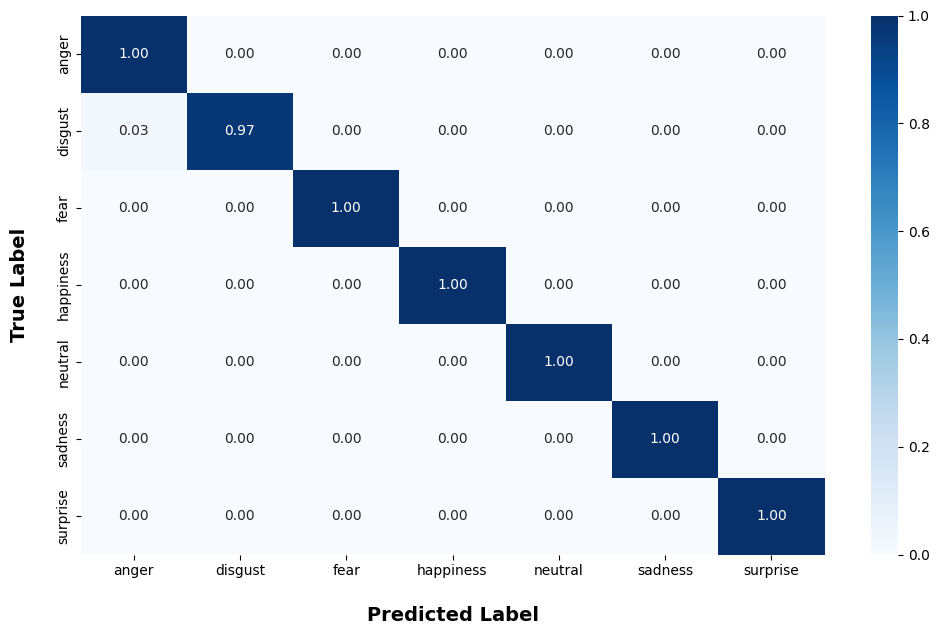

In [ ]:
classes = [v for k,v in idx2class.items()]

cf_matrix = confusion_matrix(y_true, y_preds)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize = (12,7))

s = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=".2f")

plt.xlabel('Predicted Label', fontsize=14, labelpad=20, fontweight='bold')

plt.ylabel('True Label', fontsize=14, labelpad=20, fontweight='bold')

# format_margins(s, x=0.1)

plt.savefig('./confusion_matrix_savee.png')

plt.show()

In [ ]:
# # Save stats
# with open("./recorded.txt", "w") as f:
#     f.write("R2plus1D & VGG1D-BiLSTM attempt\n")
#     for i, line in enumerate(epochs):
#         f.write(f"Epoch: {line}: | Train Loss: {train_loss_history[i]} | Train Accuracy: {train_accuracy_history[i]} | Eval Loss: {eval_loss_history[i]} | Eval Accuracy: {eval_accuracy_history[i]}")
#         f.write("\n")

#     f.write("\n==================================================\n")
#     f.write(f"On best weights => Test loss: {test_loss}\tTest Accuracy: {test_acc*100}")
#     f.write("\n==================================================\n\n\n")

## **Citations**

1. Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391